In [1]:
import torch
import torch.nn as nn
from models import DualGridMLMMelHarm
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_masking
from generate_utils import generate_files_with_greedy, generate_files_with_beam, load_SE_model
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import save_attention_maps_with_split

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
name_suffix = 'Q16_L320_bar_FR'
print(int(name_suffix.split('_L')[1].split('_')[0]))
tokenizer = CSGridMLMTokenizer(
        fixed_length=int(name_suffix.split('_L')[1].split('_')[0]),
        quantization='16th' if 'Q16' in name_suffix else '4th',
        intertwine_bar_info='bar' in name_suffix,
        trim_start=False,
        use_pc_roll='PC' in name_suffix,
        use_full_range_melody='FR' in name_suffix
    )
val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
# val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_train'
# val_dir = '/media/maindisk/data/synthetic_CA_test'

320


In [3]:
val_dataset = CSGridMLMDataset(
    root_dir=val_dir,
    tokenizer=tokenizer,
    name_suffix=name_suffix
)

Loading data file.


In [4]:
d = val_dataset[0]
print(d.keys())
print(len(d['harmony_ids']))
print(d['pianoroll'].shape)
print(tokenizer.pianoroll_dim)

dict_keys(['harmony_ids', 'attention_mask', 'pianoroll', 'time_signature', 'h_density_complexity'])
320
(320, 89)
89


In [5]:
import os
data_files = []
for dirpath, _, filenames in os.walk(val_dir):
    for file in filenames:
        if file.endswith('.xml') or file.endswith('.mxl') or file.endswith('.musicxml') \
            or file.endswith('.mid') or file.endswith('.midi'):
            full_path = os.path.join(dirpath, file)
            data_files.append(full_path)
print(len(data_files))

758


In [33]:
val_dataset = CSGridMLMDataset(val_dir, tokenizer, name_suffix='Q4_L80_bar_PC')

Loading data file.


In [34]:
val_idx = 0
d = val_dataset[val_idx]
harmony_tokens = []
for i in d['harmony_ids']:
    harmony_tokens.append(tokenizer.ids_to_tokens[i])

In [35]:
print(harmony_tokens)

['<bar>', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'F:maj', 'F:maj', 'D:min', 'D:min', '<bar>', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'F:maj', 'F:maj', 'D:min', 'D:min', '<bar>', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'F:maj', 'F:maj', 'D:min', 'D:min', '<bar>', 'A:min', 'A:min', 'A:min', 'A:min', '<bar>', 'F:maj', 'F:maj', 'D:min', 'D:min', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [36]:
import matplotlib.pyplot as plt

In [37]:
print(d.keys())

dict_keys(['harmony_ids', 'attention_mask', 'pianoroll', 'time_signature', 'h_density_complexity'])


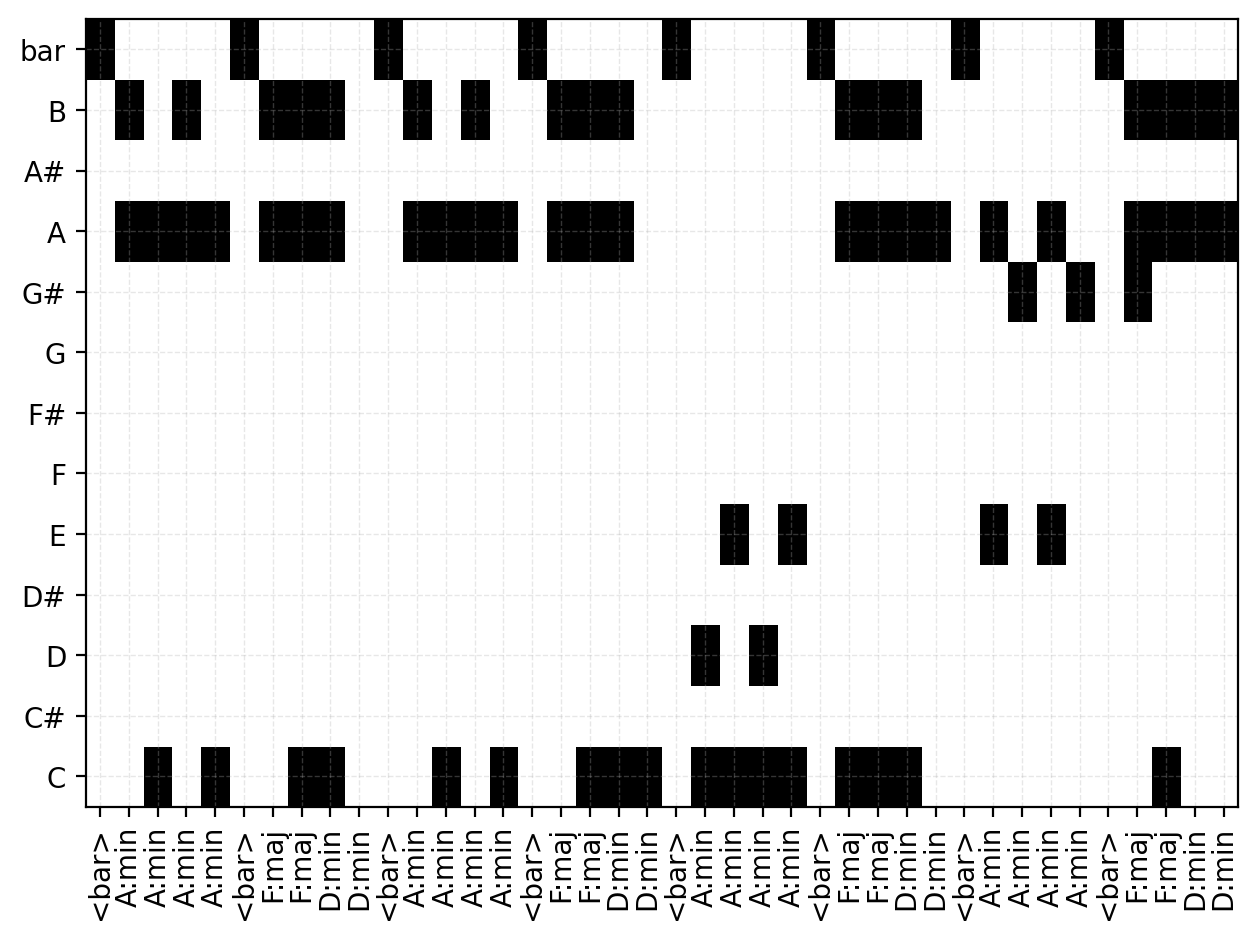

In [41]:
plt.imshow(d['pianoroll'][:40].T, aspect='auto', origin='lower', cmap='gray_r')
plt.xticks(ticks=range(40), labels=harmony_tokens[:40], rotation=90)
plt.yticks(ticks=range(13), labels=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','bar'])
plt.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.tight_layout()  # Optional: ensures labels fit
plt.savefig('figs/pianoroll_example.png', dpi=300)
plt.show()